<a href="https://colab.research.google.com/github/ikonushok/My_studying_Data-Science-and-Neyro-Nets-on-Python/blob/master/%D0%94%D0%97_12_Pro_v1_%D0%A1%D0%B5%D0%B3%D0%BC%D0%B5%D0%BD%D1%82%D0%B0%D1%86%D0%B8%D1%8F%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pro задание. Вариант 1
----
Напишите PSPNet для сегментации на базе стройки, добейтесь максимально возможной точности.

https://medium.com/analytics-vidhya/semantic-segmentation-in-pspnet-with-implementation-in-keras-4843d05fc025

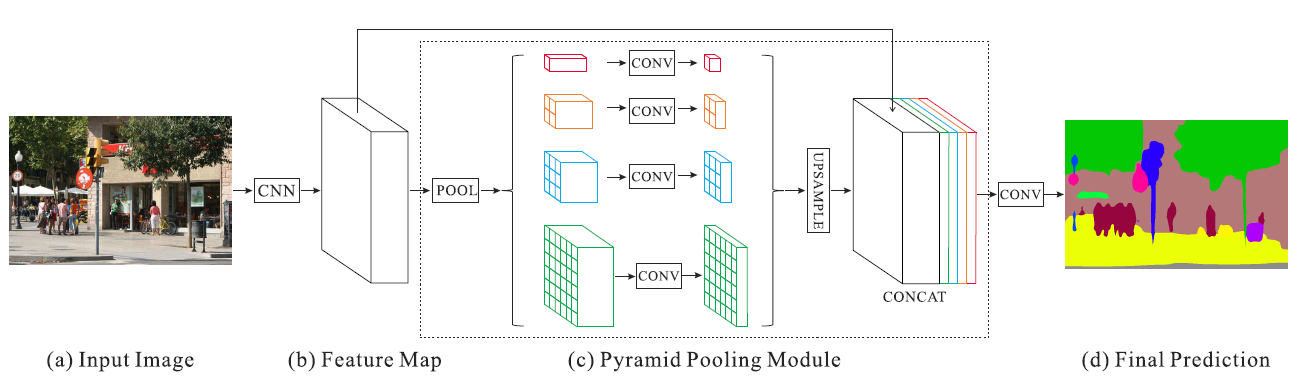

## Подключение бибилиотек

*Разбор данного раздела:* https://youtu.be/E8RsblFqFZs?t=698

In [85]:
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.layers import (Input, Conv2DTranspose, concatenate, Activation,
                                     MaxPooling2D, Conv2D, BatchNormalization,
                                     UpSampling2D, LeakyReLU) # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam, Nadam, Adamax # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
from google.colab import files # Импортируем Модуль files для работы с файлами
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from IPython.display import clear_output
import numpy as np # Импортируем библиотеку numpy
from sklearn.model_selection import train_test_split
from keras.layers.advanced_activations import LeakyReLU # импортируем функцию активации отдельным слоем
from keras.utils import plot_model
import time, random, os

from PIL import Image # импортируем модель Image для работы с изображениями

In [5]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Глобальные параметры
img_width = 176 # Ширина уменьшенной картинки 
img_height = 240 # Высота уменьшенной картинки 
num_classes = 7 # Задаем количество классов на изображении
directory = '/content/drive/My Drive/Занятие_12_Сегментация/Сегментация/' # Указываем путь к обучающей выборке с оригинальными изображения
train_directory = 'Тренировочная_стройка' # Название папки с файлами обучающей выборки
val_directory = 'Проверочная_стройка' # Название папки с файлами проверочной выборки

## Загрузка картинок

*Разбор данного раздела:* https://youtu.be/E8RsblFqFZs?t=752


In [8]:
os.chdir('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка')
xTrain, yTrain = np.load('xTrain.npy'), np.load('yTrain.npy')
xVal, yVal= np.load('xVal.npy'), np.load('yVal.npy')
print('xTrain\t', xTrain.shape, '\nyTrain\t', yTrain.shape,
      '\nxVal\t', xVal.shape, '\nyVal\t', yVal.shape)

xTrain	 (900, 176, 240, 3) 
yTrain	 (900, 176, 240, 7) 
xVal	 (50, 176, 240, 3) 
yVal	 (50, 176, 240, 7)


## Функции визуализации и ошибок

*Разбор данного раздела:* https://youtu.be/E8RsblFqFZs?t=2056

In [9]:
# Функция визуализации сегментированных изображений
def processImage(model, count = 1, n_classes = 6):
  indexes = np.random.randint(0, len(xVal), count) # Получаем count случайных индексов
  fig, axs = plt.subplots(3, count, figsize=(16, 6)) #Создаем полотно из n графиков
  for i,idx in enumerate(indexes): # Проходим по всем сгенерированным индексам
    predict = np.array(model.predict(xVal[idx].reshape(1, img_width, img_height, 3))) # Предиктим картику
    pr = predict[0] # Берем нулевой элемент из перидкта
    pr1 = [] # Пустой лист под сегментированную картинку из predicta
    pr2 = [] # Пустой лист под сегменитрованную картинку из yVal
    pr = pr.reshape(-1, n_classes) # Решейпим предикт
    yr = yVal[idx].reshape(-1, n_classes) # Решейпим yVal
    for k in range(len(pr)): # Проходим по всем уровням (количесвто классов)
      pr1.append(index2color(pr[k])) # Переводим индекс в писксель
      pr2.append(index2color(yr[k])) # Переводим индекс в писксель
    pr1 = np.array(pr1) # Преобразуем в numpy
    pr1 = pr1.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    pr2 = np.array(pr2) # Преобразуем в numpy
    pr2 = pr2.reshape(img_width, img_height,3) # Решейпим к размеру изображения
    img = Image.fromarray(pr1.astype('uint8')) # Получаем картику из предикта
    axs[0,i].imshow(img.convert('RGBA')) # Отображаем на графике в первой линии
    axs[1,i].imshow(Image.fromarray(pr2.astype('uint8'))) # Отображаем на графике во второй линии сегментированное изображение из yVal
    axs[2,i].imshow(Image.fromarray(xVal[idx].astype('uint8'))) # Отображаем на графике в третьей линии оригинальное изображение        
  plt.show()  

In [10]:
'''
  Собственная функция метрики, обрабатывающая пересечение двух областей
'''
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.) # Возвращаем площадь пересечения деленную на площадь объединения двух областей

In [11]:
# Функция преобразования индекса в цвет пикселя
def index2color(index2):
  index = np.argmax(index2) # Получаем индекс максимального элемента
  color=[]
  if   index == 0: color = [100, 100, 100]  # пол
  elif index == 1: color = [0, 0, 100]  # потолок
  elif index == 2: color = [0, 100, 0]  # стена
  elif index == 3: color = [100, 0, 0]  # проем, дверь, окно
  elif index == 4: color = [0, 100, 100]  # колонна, лестница, внешний мир, перила, батарея, инвентарь, источники света, провода, балка
  elif index == 5: color = [100, 0, 100]  # люди
  elif index == 6: color = [0, 0, 0]  # остальное
  return color # Возвращаем цвет пикслея

# PSPNet


### Создание и обучение сети

In [158]:
'''
  Функция создания сети
    Входные параметры:
    - num_classes - количество классов
    - input_shape - размерность карты сегментации
'''
def PSPNetWithMask(num_classes, input_shape = (img_width, img_height, 3)): #(352, 480, 3)):
    img_input = Input(input_shape)
    # Операции со сверткой и сегментация
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = LeakyReLU()(x)
    x = Conv2D(32, (3, 3), padding='same', name='block1_conv2')(x)
    x = LeakyReLU()(x)
    # Pooling пирамида
    block_1_out = MaxPooling2D((2,2))(x)
    block_1_out = BatchNormalization()(block_1_out)
    block_2_out = MaxPooling2D((4,4))(x)
    block_2_out = BatchNormalization()(block_2_out)
    block_3_out = MaxPooling2D((8,8))(x) 
    block_3_out = BatchNormalization()(block_3_out)
    block_4_out = MaxPooling2D((16,16))(x)
    block_4_out = BatchNormalization()(block_4_out)
    # Сверточные слои
    block_1_out = Conv2D(512,(5,5), padding='same', name='block1_conv3')(block_1_out)
    block_1_out = BatchNormalization()(block_1_out)
    block_1_out = LeakyReLU()(block_1_out)
    block_2_out = Conv2D(512,(5,5), padding='same', name='block2_conv3')(block_2_out)
    block_2_out = BatchNormalization()(block_2_out)
    block_2_out = LeakyReLU()(block_2_out) 
    block_3_out = Conv2D(512,(5,5), padding='same', name='block3_conv3')(block_3_out)
    block_3_out = BatchNormalization()(block_3_out)
    block_3_out = LeakyReLU()(block_3_out) 
    block_4_out = Conv2D(512,(5,5), padding='same', name='block4_conv3')(block_4_out)
    block_4_out = BatchNormalization()(block_4_out)
    block_4_out = LeakyReLU()(block_4_out)

    # Увеличиваем размерность
    block_1_out = Conv2DTranspose(32,(2,2), strides=(2,2), padding='same')(block_1_out)
    #block_1_out = UpSampling2D(size=(2,2), interpolation='nearest')(block_1_out)
    block_1_out = LeakyReLU()(block_1_out)
    block_2_out = Conv2DTranspose(32,(4,4), strides=(4,4), padding='same')(block_2_out)
    #block_2_out = UpSampling2D(size=(4,4), interpolation='nearest')(block_2_out)
    block_2_out = LeakyReLU()(block_2_out)
    block_3_out = Conv2DTranspose(32,(8,8), strides=(8,8), padding='same')(block_3_out)
    #block_3_out = UpSampling2D(size=(8,8), interpolation='nearest')(block_3_out)
    block_3_out = LeakyReLU()(block_3_out)
    block_4_out = Conv2DTranspose(32,(16,16), strides=(16,16), padding='same')(block_4_out)
    #block_4_out = UpSampling2D(size=(16,16), interpolation='nearest')(block_4_out)
    block_4_out = LeakyReLU()(block_4_out)

    # Объединяем слои
    out = concatenate([block_1_out, block_2_out, block_3_out, block_4_out])
    out = Conv2D(num_classes, (3,3), activation = 'softmax', padding = 'same')(out)
    # Выходной слой

    model = Model(img_input, out) 

    # Компилируем модель 
    model.compile(optimizer=Adam(decay=5e-4),
                  loss='categorical_crossentropy', metrics=[dice_coef])
    
    return model 

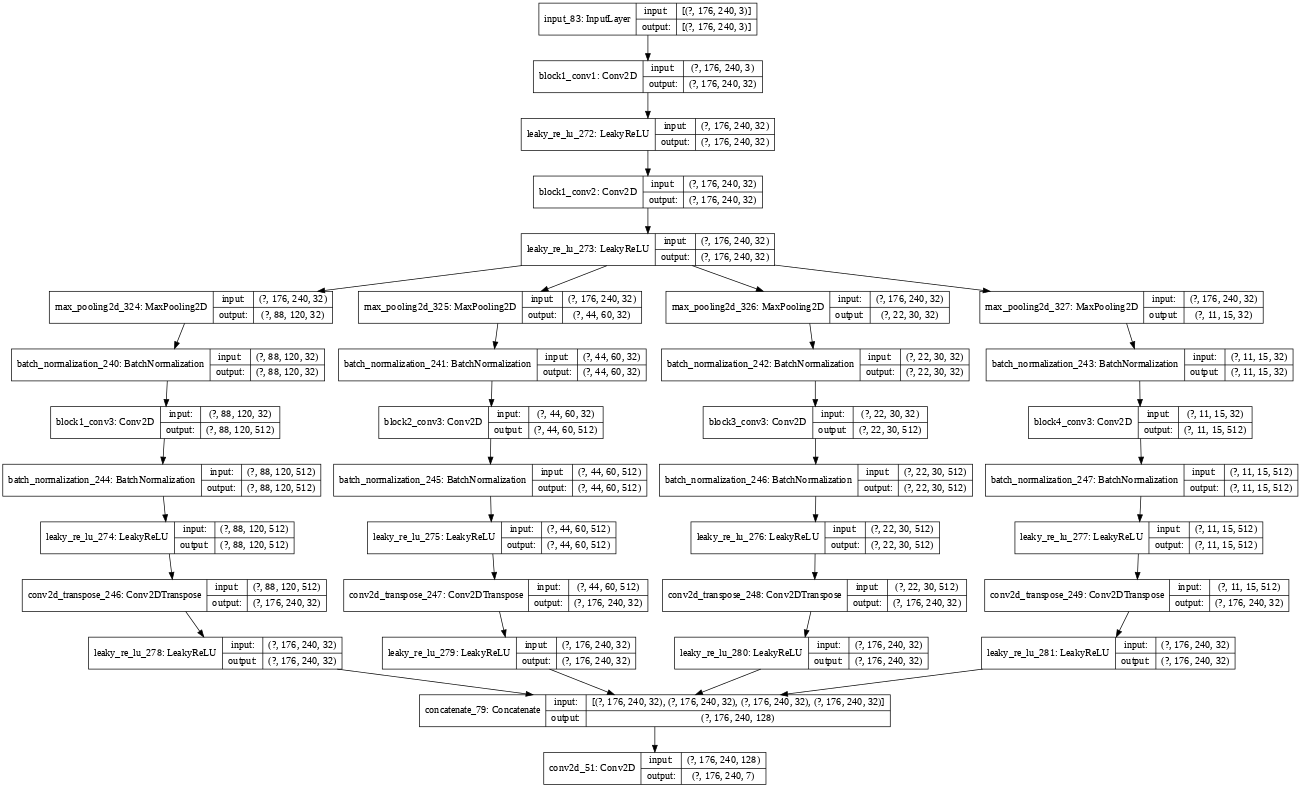

In [145]:
plot_model(model, dpi=50, show_shapes=True, show_layer_names=True)

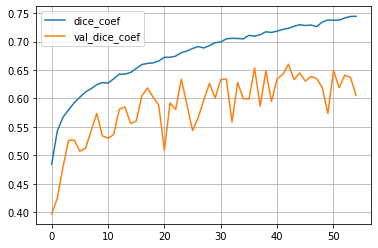

In [159]:
modelPSPNet = PSPNetWithMask(num_classes, (img_width, img_height, 3))

#Коллбэки
early_stopping = EarlyStopping(monitor = 'val_dice_coef', patience = 12, verbose = 0, restore_best_weights = True, mode='max')
#reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.6, patience=6, min_lr=1e-06, verbose = 1, mode='max')
Checkpoint = ModelCheckpoint('modelPSPNet.h5', monitor='val_dice_coef', verbose=1, save_best_only=True, save_weights_only=True, mode='max')

# Обучаем модель simpleUnet
history = modelPSPNet.fit(xTrain, yTrain, validation_data = (xVal, yVal),
                          epochs=100, batch_size=10, verbose=0,
                          callbacks = [early_stopping, Checkpoint])

#Выводим график точности распознавания на обучающей и проверочной выборках
clear_output()
plt.plot(history.history['dice_coef'], label='dice_coef')
plt.plot(history.history['val_dice_coef'], label='val_dice_coef')
plt.legend()
plt.grid()
plt.show()

### Распознавание сразу всех обьектов

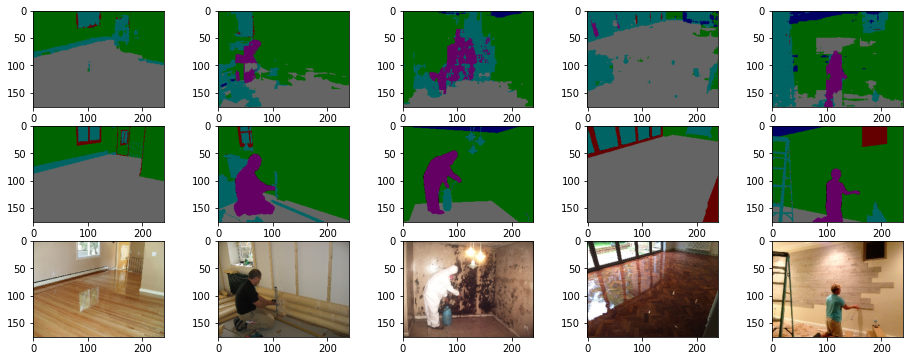

In [117]:
modelPSPNet = PSPNetWithMask(num_classes, (img_width, img_height, 3))
modelPSPNet.load_weights('/content/drive/My Drive/Занятие_12_Сегментация/data_стройка/modelPSPNet.h5')
processImage(modelPSPNet, 5, num_classes)

# Выводы:
-----
1. Лучше делать отдельные нейронки для каждого класса обьектов
2. Сетка достаточно быстрая, поэтому, если делать на 1 обьект, а не на все сразу, то вариант простой и хороший